# 1. Setup

In [1]:
import requests

from sklearn.decomposition import PCA

from utils import *

## 1.1. Load zones

In [2]:
state_list = pd.read_csv(DATA / 'zones/state_codes.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
us_counties = (gpd.read_parquet(DATA / 'zones/us/county_trim.parquet').set_crs(CRS_M)
               .rename(columns=D(geoid='cnty', name='county'))).disp()

3,108 rows x 4 cols; Memory: 0.4 MiB; CRS: EPSG:3857


,cnty,county,aland,geometry
,<object>,<object>,<int64>,<geometry>
0,01001,Autauga,1539634184,"POLYGON ((-9624353.111696 3816718.739514, -962..."


In [4]:
bg_msa = (gpd.read_parquet(DATA / 'zones/msa_2020.parquet', filters=[
    ('scale', '==', 'bg')], columns=['geoid', 'region', 'geometry'])
         .to_crs(CRS_M).assign(cnty=lambda df: df.geoid.str[:5])).disp()

123,395 rows x 4 cols; Memory: 24.1 MiB; CRS: EPSG:3857


,geoid,region,geometry,cnty
,<object>,<object>,<geometry>,<object>
0,010070100011,birmingham,"POLYGON ((-9719547.306331 3906895.592179, -971...",01007


### 3.4.1. Regional zones of Cook County

In [5]:
bg_chi = bg_msa.query('region=="chicago"').drop(columns='region').disp(0)
bg_cook = bg_chi.query('cnty=="17031"').disp(0)

6,723 rows x 3 cols; Memory: 0.9 MiB; CRS: EPSG:3857


,geoid,geometry,cnty
,<object>,<geometry>,<object>


4,001 rows x 3 cols; Memory: 0.6 MiB; CRS: EPSG:3857


,geoid,geometry,cnty
,<object>,<geometry>,<object>


### 3.4.2. Regional zones of South Chicago

In [6]:
# zones of South Chicago
bg_schi = gpd.read_file(DATA / 'ses/high_sedi_rgn_cook.gpkg').drop(columns='sedi').disp(0)

1,258 rows x 2 cols; Memory: 0.1 MiB; CRS: EPSG:3857


,geoid,geometry
,<object>,<geometry>


# 2. ACS

## 2.1. Explore fields

### 2.1.1. Download fields

In [7]:
def get_acs_fields(year: int, five_year=True, table_type='B',
                   exclude_derivative_tables=True,
                   exclude_quality_vars=True,
                   exclude_detailed_tables=True,
                   save=True, overwrite=False):
    assert year <= 2021
    assert table_type in [None, 'B', 'C']
    outpath = DATA / f'ses/acs_{year}_fields.csv'
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath).set_index('fid')
    product = 'acs5' if five_year else 'acs1'
    url = f'https://api.census.gov/data/{year}/acs/{product}/variables'
    resp = requests.get(url)
    if resp.status_code != 200:
        raise ValueError('Could not fetch data: status code={}'
                        .format(resp.status_code))
    df = Pdf(resp.json()[4:], columns=['fid', 'fname', 'tname']).dropna()
    df = df[df.fid.str[0].isin(['B', 'C'])].dropna(subset='tname')
    df.fname = (df.fname.str.lower()
                .str.replace('!!', '__')
                .str.replace(':', '')
                .str.replace('estimate__', ''))
    df.tname = (df.tname.str.lower()
                .str.replace('in the past 12 months', 'last year')
                .str.replace('in the past year', 'last year')
                .str.replace(' years and over', '+ yr')
                .str.replace(f'in {year} inflation-adjusted dollars', 'in IA$'))
    df['tid'] = df.fid.str.split('_').str[0]
    df['fnum'] = df.fid.str.split('_').str[1].str[:-1]
    # filter only the given base tables
    if table_type:
        df = df[df.tid.str[0] == table_type]
    # remove derivative tables (that have suffixes in their IDs)
    if exclude_derivative_tables:
        df = df[df.tid.str[1:].str.isdigit()]
    # remove tables related to survey data quality
    if exclude_quality_vars:
        df = df[df.tid.str[1:3] <= '90']
    # remove detailed tables (they contain way too many variables!)
    if exclude_detailed_tables:
        df = df[~df.tname.str.startswith('detailed')]
    df = df.set_index('fid').sort_index()
    if save:
        df.to_csv(mkfile(outpath))
    return df
    
cols19 = get_acs_fields(year=2019, overwrite=0).disp(3)

13,624 rows x 4 cols; Memory: 5.1 MiB


,fname,tname,tid,fnum
fid,<object>,<object>,<object>,<int64>
B01001_001E,total,sex by age,B01001,1
B01001_002E,total__male,sex by age,B01001,2
B01001_003E,total__male__under 5 years,sex by age,B01001,3


### 2.1.2. Create field tree
Write a YAML file from the indents of the columns.
This may not always work since the input data indent structure could be flawed (e.g., in table B02016).

In [8]:
def make_field_tree(year: int, overwrite=False):
    outpath = DATA / f'ses/acs_{year}_field_tree.yaml'
    if outpath.exists() and not overwrite:
        return
    cols = pd.read_csv(DATA / f'ses/acs_{year}_fields.csv')
    cols['indent'] = cols.fname.str.split('__').str.len()
    cols['leaf'] = list(cols.indent.diff()[1:] <= 0) + [True]
    res = []
    for (tid, tname), df in cols.groupby(['tid', 'tname']):
        res.append(f'<{tid}> {tname}:')
        for _, r in df.iterrows():
            pfx = '  ' * r.indent + f'- <{r.fnum}>'
            name = r.fname.split('__')[-1]
            sfx = '' if r.leaf else ':'
            res.append(f'{pfx} {name}{sfx}')
    with open(outpath, 'w') as f:
        f.write('\n'.join(res))

make_field_tree(2019)

### 2.1.3. Define fields of interest

In [9]:
acs_cols = tuple(sorted([
    ## _Overall
    'B01001_001E', # total population
    'B19001_001E', # total households
    ## Age
    'B06001_002E', # population in the US aged ≤4 y
    'B16004_002E', # population of minors (aged 5-17 y)
    # 'B16004_046E', # population of seniors (aged ≥65 y)
    # 'B01002_001E', # median age of the entire population
    ## Commute mode
    # total workers aged ≥16 y by commute mode
    *[f'B08301_{x:03}E' for x in (1,10,18,19,21)],
    ## Disability
    # total civilian noninstitutionalized population by disability status
    *[f'B18135_{x:03}E' for x in (1,2,13,25)],
    # total households having received food stamps
    *[f'B22010_{x:03}E' for x in (1,3,6)],
    ## Education
    # total population aged ≥25 y by highest degree attained
    *[f'B15003_{x:03}E' for x in (1,18,19,20,21,22,23,24,25)],
    ## Employment
    'B23025_002E', # population of labor force (aged ≥16 y)
    'B23025_005E', # unemployed population in labor force
    ## Family
    # total households by family type
    *[f'B11012_{x:03}E' for x in (3,6,10,15)],
    ## Health insurance
    # total civilian noninstitutionalized population by health insurance coverage
    *[f'B27010_{x:03}E' for x in (1,17,33,50,66)],
    ## Housing
    # total population in occupied housing units by tenure
    *[f'B25033_{x:03}E' for x in (1,8,6,13)],
    # total housing units by occupants per room
    *[f'B25014_{x:03}E' for x in (1,5,6,7,11,12,13)],
    ## Income & poverty
    'B19301_001E', # median household income (inflation-adjusted USD)
    'B17021_001E', # total population for whom poverty status is determined
    'B17021_002E', # eligible population with income less than poverty level
    # total families with given income to poverty level ratio
    *[f'B17026_{x:03}E' for x in range(1, 10)],
    'B22010_002E', # total households having received food stamps/SNAP last year
    ## Language
    # total population aged ≥5 y by language spoken at home & English proficiency
    *[f'B16004_{x:03}E' for x in (1,7,8,12,13,17,18,22,23,29,30,34,35,39,40,44,45,51,52,56,57,61,62,66,67)],
    ## Race
    'B02001_002E', # total White population
    'B02001_003E', # total Black population
    ## Vehicle ownership
    # total occupied housing units by number of vehicles available
    *[f'B25044_{x:03}E' for x in (1,3,10)],
    'B25046_001E', # aggregate number of vehicles available
]))

## 2.2. Prepare data

### 2.2.1. Define derived features

- **Demographics**:
    - `POPU`: total population
    - `POP_DENSITY`: population density (per sq. mi.)
    - `P_MINOR`: proportion of popu aged ≤18 y
    - `P_POC`: proportion of people of color (non-White)
    - `P_LOWENGLISH`: proportion of population in limited English-speaking households
- **Economic**:
    - `M_INCOME`: per capita income in the last year, measured as the complement of the normalized log of  inflation-adjusted value in USD
    - `P_POV`: proportion of eligible population below poverty level
    - `P_POV150`: proportion of families with income less than 1.5 times poverty level
    - `P_POV200`: proportion of families with income less than 2 times poverty level
    - `P_SNAP`: proportion of households having received food stamps/SNAP last year
    - `P_UNEMPLOY`: proportion of labor force unemployed
- **Health & Education**:
    - `P_LOWEDU`: proportion people above 25 years with highest degree high shcool or lesser
    - `P_NOINSUR`: proportion of population without health insurance coverage
    - `P_DISABLED`: proportion of eligible population with a disability
- **House & Family**:
    - `P_SNGLPARENT`: proportion of households with children that are led by single parents
    - `P_CROWDED`: proportion of households that are crowded (>1.01 persons per room)
    - `P_RENTER`: proportion of housing units occupied by renters
    - `P_MOBILEHOME`: proportion of occupied housing units that are mobile homes
- **Transport**:
    - `P_NOVEH`: proportion of households not owning any vehicle
    - `M_HHPERVEH`: mean no. of households per vehicle
    - `P_NOWFH`: proportion of workers who do not (or cannot) work from home
    - `P_TRANSIT`: proportion of commuting workers using public transit
    - `P_WALKBIKE`: proportion of commuting workers who commute by walking or bicylcing

In [10]:
get_acs_ses = lambda x: dict(
    ## Overall
    popu = x.B01001_001E,
    ## Age
    # median age of population
    # m_age = x.B01002_001E,
    # proportion of popu aged ≤18 y
    p_minor = x.B16004_002E / x.B01001_001E,
    # proportion of popu aged ≥64 y
    # p_senior = x.B16004_046E / x.B01001_001E,
    ## Race
    # proportion people of color (non-White)
    p_poc = 1 - x.B02001_002E / x.B01001_001E,
    # proportion Black people
    # p_black = x.B02001_003E / x.B01001_001E,
    ## Education
    # proportion people above 25 years with highest degree high shcool or lesser
    p_lowedu = 1 - (x.B15003_018E + x.B15003_019E + x.B15003_020E + x.B15003_021E + x.B15003_022E + x.B15003_023E + x.B15003_024E + x.B15003_025E) / x.B15003_001E,
    ## Income & poverty
    # per capita income in the last year, measured as the complement 
    # of the normalized log of the inflation-adjusted value in USD
    m_income = 1 - normalize(np.log10(1 + x.B19301_001E)),
    # proportion of eligible population below poverty level
    p_pov = x.B17021_002E / x.B17021_001E,
    # proportion of families with income less than 1.5 times poverty level
    p_pov150 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E) / x.B17026_001E,
    # proportion of families with income less than 2 times poverty level
    p_pov200 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E + x.B17026_007E + x.B17026_008E + x.B17026_009E) / x.B17026_001E,
    # proportion of households having received food stamps/SNAP last year
    p_snap = x.B22010_002E / x.B19001_001E,
    ## Employment
    # proportion of labor force unemployed
    p_unemploy = x.B23025_005E / x.B23025_002E,
    ## Health & disability
    # proportion of population without health insurance
    p_noinsur = (x.B27010_017E + x.B27010_033E + x.B27010_050E + x.B27010_066E) / x.B27010_001E,
    # proportion of eligible population with a disability, including
    # difficulty in hearing, vision, cognition, self-car, indendent living, ambulation
    p_disabled = (x.B22010_003E + x.B22010_006E) / x.B22010_001E,
    ## Language
    # proportion of population in limited English-speaking households
    p_lowenglish = pd.concat([x[f'B16004_{i:03}E'] for i in (7, 8, 12, 13, 17, 18, 22, 23, 29, 30, 34, 35, 39, 40, 44, 45, 51, 52, 56, 57, 61, 62, 66, 67)], axis=1).sum(1) / x.B16004_001E,
    ## Family
    # proportion of households with children that are led by single parents
    p_snglparent = (x.B11012_010E + x.B11012_015E) / (x.B11012_003E + x.B11012_006E + x.B11012_010E + x.B11012_015E),
    # proportion of population living in institutionalized group quarters
    # p_grpquarter = x.B26103_003E / x.B26103_001E,
    p_crowded = (x.B25014_005E + x.B25014_006E + x.B25014_007E + x.B25014_011E + x.B25014_012E + x.B25014_013E) / x.B25014_001E,
    ## Housing
    # proportion of housing units occupied by renters
    p_renter = x.B25033_008E / x.B25033_001E,
    # proportion of occupied housing units that are mobile homes
    p_mobilehome = (x.B25033_006E + x.B25033_013E) / x.B25033_001E,
    ## Transport
    # proportion of households not owning any vehicle
    p_noveh = (x.B25044_003E + x.B25044_010E) / x.B25044_001E,
    # mean no. of households per vehicle
    m_hhperveh = x.B25044_001E / x.B25046_001E,
    # proportion of workers who do not (or cannot) work from home
    p_nowfh = 1 - (x.B08301_021E / x.B08301_001E),
    # proportion of commuting workers using public transit
    p_transit = x.B08301_010E / (x.B08301_001E - x.B08301_021E),
    # proportion of commuting workers who commute by walking or bicylcing
    p_walkbike = (x.B08301_018E + x.B08301_019E) / (x.B08301_001E - x.B08301_021E),
)

### 2.2.2. Download and process fields

In [11]:
def download_acs(geo, fields, src='acs5', year=2020, table_type='detail', key=None):
    """Download the data of the given ACS fields for a given region.

    Parameters
    ----------
    geo : list[tuple[str, str]]
        Regional geography defined as a list of subregions (e.g., a state is
        made of counties). The geographical hierarchy is to be defined as a list
        or tuple of 2-tuples: (geographical scale, search criteria). Here, the
        search criterion can be the FIPS code of the region or wildcard. E.g.,
        geo = [('state', '18'), ('county', '*')] for all counties in Indiana.
        For more details, see the API document:
        https://census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf
    fields : list[str]
        List of codes for the data fields of interest. E.g., ['B01001E',
        'C15027PR', ...]
    src : str
        Source of the dataset: must be one of {'acs1', 'acs5', 'acsse'}.
    year : int
        Year of the dataset.
    table_type : str
        Table type as defined by the US Census. Allowed values are the 1 or
        2-character codes as defined in the `id` column of `mk.acs.TABLE_TYPES`.
    key : str
        Census Data API key (optional but highly recommended).
    Returns
    -------
    pandas.DataFrame
        Table with the rows denoting the spatial units, the index denoting their
        identity hierarchy, and the columns named the same as :attr:`fields` and
        having the data values.
    """
    assert src in ['acs1', 'acs5', 'acsse', 'sf1']
    assert table_type in ['detail', 'profile', 'subject']
    geo_ = [(x[0].replace(' ', '+'), x[1]) for x in geo]
    for_ = '&for=' + ':'.join(geo_.pop(-1))
    in_ = '&in=' + '+'.join(':'.join(x) for x in geo_)
    key = f'&key={key}' if isinstance(key, str) else ''
    chunksize = 49
    root = 'https://api.census.gov/data'
    res = Pdf()
    for i in range(0, len(fields), chunksize):
        cols = fields[i : (i+chunksize)]
        get = 'get=' + ','.join(cols)
        url = f'{root}/{year}/acs/{src}?{get}{for_}{in_}{key}'
        resp = requests.get(url)
        try:
            data = resp.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            id_cols = [x for x in df.columns if x not in cols]
            res = pd.concat([res, df.set_index(id_cols)], axis=1)
        except Exception as e:
            print('Failed fetching', cols, e)
    return res.astype(float)

# x = download_acs([('state', '01'), ('county', '*')], acs_cols, year=2021); x

API key requested from the Census Bureau on Nov 2, 2023 via [a form](https://api.census.gov/data/key_signup.html).

In [12]:
def get_acs(year=2019, fields=acs_cols, states=state_list, overwrite=False,
            key='6bc2ce9d18094b273fb5f774799dfa9fdf6d366e'):
    outpath = DATA / f'ses/acs_{year}.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    if isinstance(fields, str): fields = [fields]
    zone_year = (year // 10) * 10
    geos = {'county': [[('state', f'{x:02}'), ('county', '*')] 
                       for x in states['fips']]}
    geos['tract'] = [x + [('tract', '*')] for x in geos['county']]
    geos['bg'] = [x + [('block group', '*')] for x in geos['tract']]
    res = []
    for scale, geo_list in geos.items():
        for geos in tqdm(geo_list):
            df = download_acs(geos, fields, year=year, key=key).clip(0)
            df = df.reorder_levels([x[0] for x in geos])
            df = Pdf(get_acs_ses(df))
            df.insert(0, 'geoid', df.index.map(''.join))
            df.insert(0, 'scale', scale)
            if 'popu' in df:
                df = df[df['popu'] > 0]
            res.append(df.reset_index(drop=1))
    df = pd.concat(res).reset_index(drop=1)
    zones = pd.read_parquet(DATA / f'zones/state_{zone_year}.parquet')
    df = df.merge(zones[['geoid', 'aland']], on='geoid')
    df.insert(3, 'pop_density', df.popu / (df.pop('aland') / SQMI2SQM))
    df.to_parquet(mkfile(outpath))
    return df

acs21 = get_acs(2021, overwrite=0).disp() # t=9:27

322,202 rows x 25 cols; Memory: 96.0 MiB


,scale,geoid,popu,pop_density,p_minor,p_poc,p_lowedu,m_income,p_pov,p_pov150,...,p_lowenglish,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,county,01001,58239.0,0.000098,0.18,0.248699,0.368153,0.307122,0.135785,0.175641,...,0.002312,0.231925,0.014733,0.233811,0.111367,0.054081,0.497519,0.952604,0.005713,0.009721


## 2.3. SEDI
SED: Socio-Economic Disadvantage Index

In [13]:
def get_sedi(bgs, rank=True, cols=(
        'p_poc p_pov p_snglparent p_crowded p_lowedu p_renter '
        'p_noveh p_noinsur p_lowenglish p_disabled p_unemploy').split()):
    ses = pd.read_parquet(DATA / 'ses/acs_2021.parquet')
    ses = ses[['geoid', 'popu'] + cols]
    ses = bgs[['geoid']].merge(ses, on='geoid').fillna(0)
    if rank:
        sedi = ses[cols].rank(pct=True).assign(geoid=ses.geoid)
    sedi['sedi'] = ses[cols].mean(axis=1).rank(pct=True)
    sedi = (bgs[['geoid', 'geometry']].merge(sedi, on='geoid')
            .merge(ses[['geoid', 'popu']]))
    return sedi

cols_sedi = 'p_pov p_poc p_unemploy p_lowedu p_noveh p_snglparent'.split()
sedi_chi = get_sedi(bg_chi, cols=cols_sedi).disp()
sedi_cook = get_sedi(bg_cook, cols=cols_sedi); print(len(sedi_cook))
sedi_schi = get_sedi(bg_schi, cols=cols_sedi); print(len(sedi_schi))

6,709 rows x 10 cols; Memory: 0.9 MiB; CRS: EPSG:3857


,geoid,geometry,p_pov,p_poc,p_unemploy,p_lowedu,p_noveh,p_snglparent,sedi,popu
,<object>,<geometry>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,170310101001,"POLYGON ((-9759589.595086 5164433.147558, -975...",0.708898,0.639141,0.480549,0.785661,0.894321,0.142272,0.666567,434.0


3992
1258


# 3. Social Vulnerability Index

## 3.1. Download
Downloaded CSV files from https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html at county & tract level.

## 3.2. Analyze

In [14]:
sviTr = pd.read_csv(DATA / 'ses/svi_us_tract_2020.csv').rename(columns=str.lower).disp()

84,122 rows x 158 cols; Memory: 122.2 MiB


,st,state,st_abbr,stcnty,county,fips,location,area_sqmi,e_totpop,m_totpop,...,ep_asian,mp_asian,ep_aian,mp_aian,ep_nhpi,mp_nhpi,ep_twomore,mp_twomore,ep_otherrace,mp_otherrace
,<int64>,<object>,<object>,<int64>,<object>,<int64>,<object>,<float64>,<int64>,<int64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,1,Alabama,AL,1001,Autauga,1001020100,"Census Tract 201, Autauga County, Alabama",3.79357,1941,390,...,2.1,2.7,0.0,1.8,0.0,1.8,6.6,5.1,0.0,1.8


In [15]:
sviCt = pd.read_csv(DATA / 'ses/svi_us_county_2020.csv').rename(columns=str.lower)

# 4. Visualize

## 4.1. Correlation

### 4.1.1. All variables

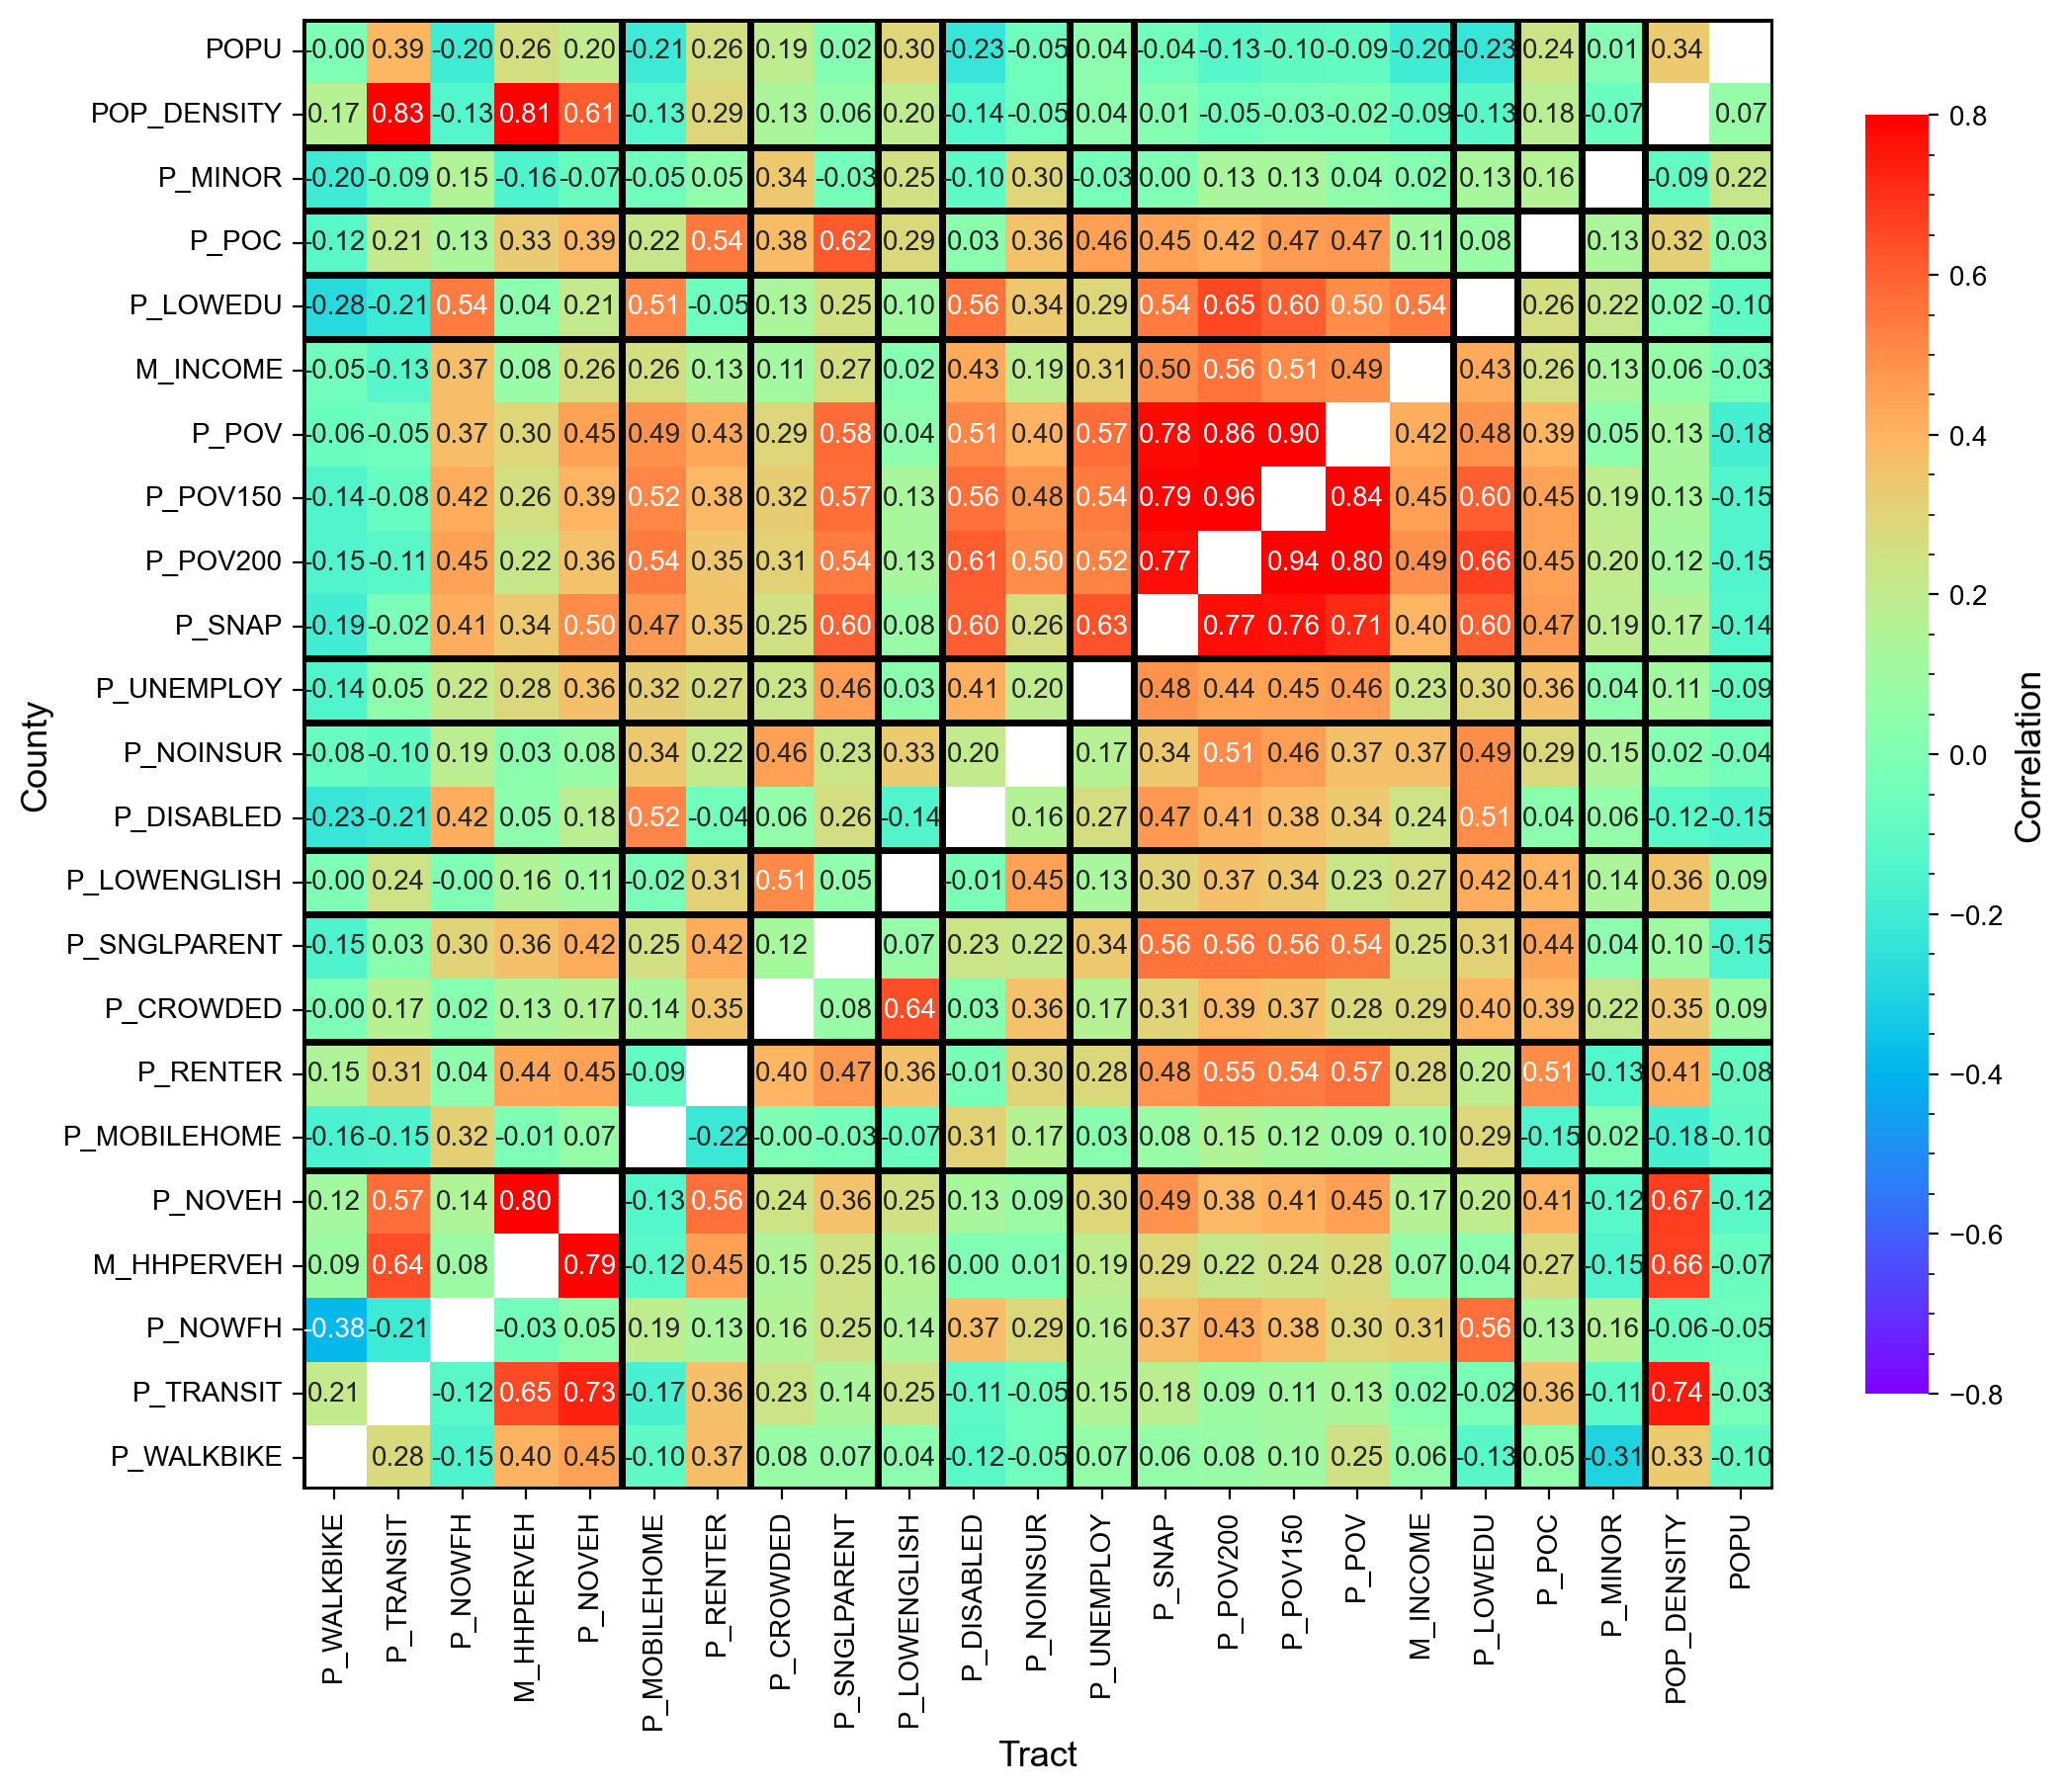

In [16]:
def plot_corr_matrix(acs):
    ax = pplot(size=(12, 12), dpi=200)
    df = acs.set_index('scale').rename(columns=str.upper).iloc[:, 1:]
    corr = np.triu(df.loc['county', :].corr(), 1) + np.tril(df.loc['tract', :].corr(), -1)
    corr = Pdf(corr, index=df.columns, columns=df.columns)
    np.fill_diagonal(corr.values, np.nan)
    sns.heatmap(corr, square=True, ax=ax, annot=True, fmt='.2f', 
                cmap='rainbow', vmax=.8, vmin=-.8,
                cbar_kws=D(shrink=0.7, label='Correlation'))
    ax.invert_xaxis(); ax.grid(alpha=0); ax.minorticks_off()
    ax = pplot(ax, xlab='Tract', ylab='County')
    for x in [0, 2, 3, 4, 5, 10, 11, 13, 14, 16, 18, 23]:
        ax.axhline(x, lw=2.5, color='k')
        ax.axvline(x, lw=2.5, color='k')
        
plot_corr_matrix(acs21)

### 4.1.2. SEDI variables

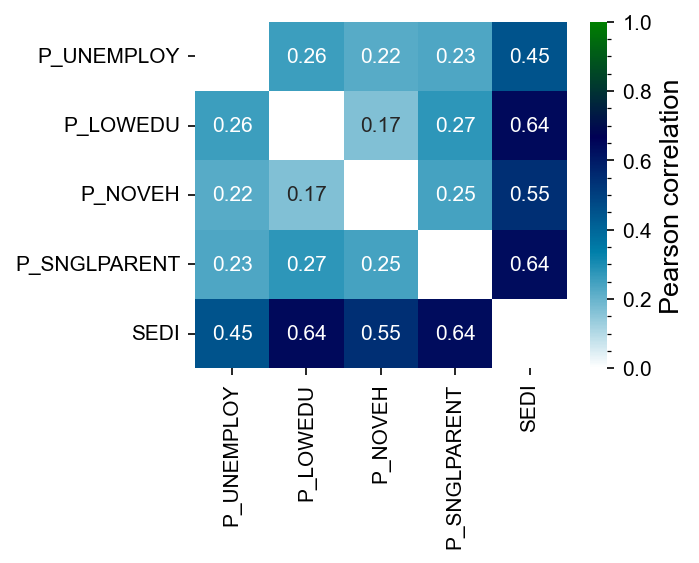

In [17]:
corr = sedi_chi[cols_sedi + ['sedi']].rename(columns=str.upper).iloc[:, 2:].corr()
np.fill_diagonal(corr.values, np.nan)
ax = sns.heatmap(corr, ax=pplot(size=(4, 3)), annot=True, cmap='ocean_r',
                 cbar_kws=D(label='Pearson correlation'),
                 vmin=0, vmax=1, fmt='.2f', annot_kws=D(fontsize=10))
ax.minorticks_off(); ax.grid(False)

### 4.1.3. Correlation b/w race and poverty

50 rows x 2 cols; Memory: 0.0 MiB


,region,corr
,<object>,<float64>
25,Milwaukee,0.668664


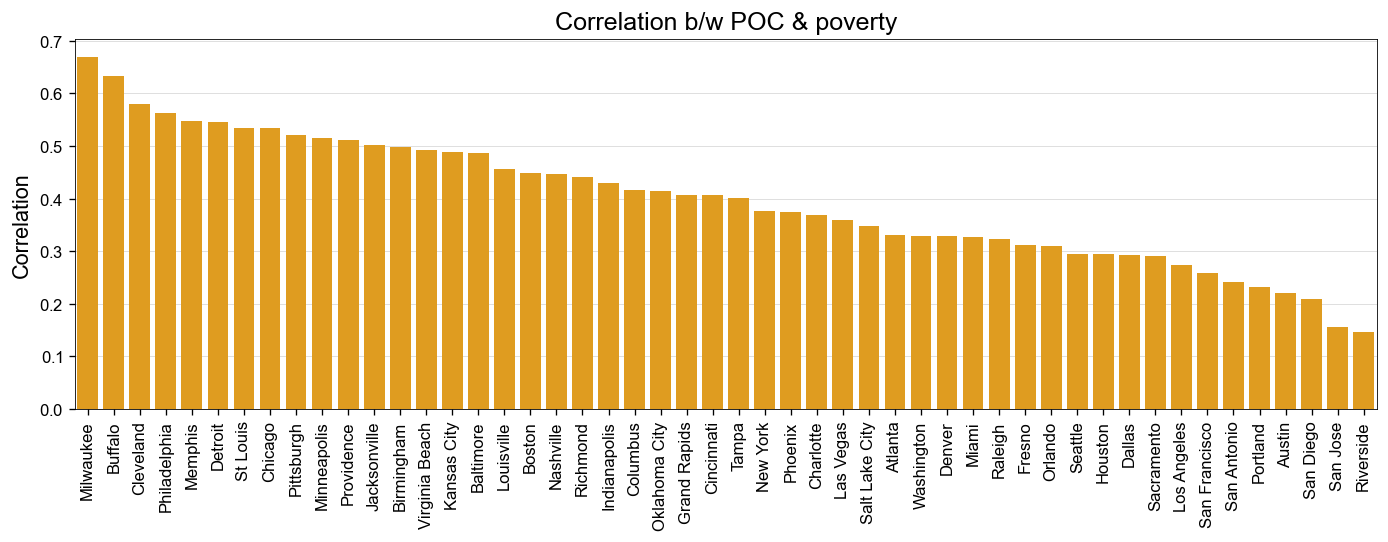

In [18]:
corr_di = (acs21.merge(bg_msa, on='geoid')
           .groupby('region')[['p_poc', 'p_pov']].corr()
           .reset_index(level=0).loc['p_pov', ['region', 'p_poc']]
           .rename(columns=D(p_poc='corr')).reset_index(drop=1)
           .assign(region=lambda df: df.region.str.replace('-', ' ').str.title())
           .sort_values('corr', ascending=False)).disp()
ax = pplot(size=(14, 4), dpi=120)
ax = sns.barplot(corr_di, x='region', y='corr', ax=ax, color='orange')
ax = pplot(ax,  ylab='Correlation', xlab='', title='Correlation b/w POC & poverty')
plt.xticks(rotation=90)
ax.minorticks_off()

## 4.2. SEDI map

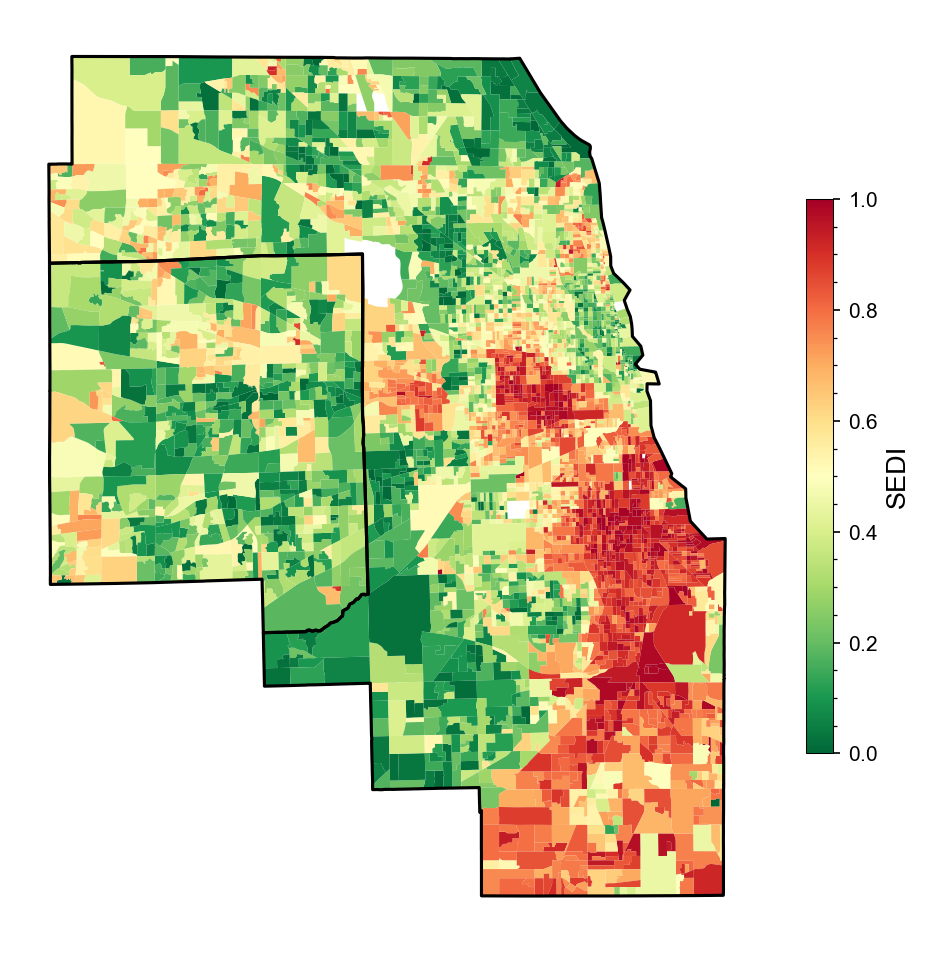

In [19]:
def plot_sedi(filt_counties=[], rank=True,
              bg=bg_msa, counties=us_counties, cols=['p_pov', 'p_poc'],
              size=(8, 8), dpi=150, cmap='RdYlGn_r', vmin=0, vmax=1):
    bg = bg.merge(counties[['cnty', 'county']], on='cnty')
    if filt_counties:
        bg = bg[bg.county.isin(filt_counties)]
    bg = bg.to_crs(CRS_M)
    cnty = counties[counties.cnty.isin(bg.cnty.unique())]
    sedi = get_sedi(bg, cols=cols, rank=rank)
    sedi = bg[['geoid', 'geometry']].merge(sedi[['geoid', 'sedi']])
    ax = pplot(size=size, dpi=dpi, axoff=1)
    sedi.plot(ax=ax, column='sedi', cmap=cmap, legend=True, legend_kwds=D(
        shrink=0.6, label='SEDI'), vmin=vmin, vmax=vmax, lw=0)
    cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)

x = plot_sedi(('Cook', 'DuPage'), vmin=0, vmax=1); x

## SEDI correlation

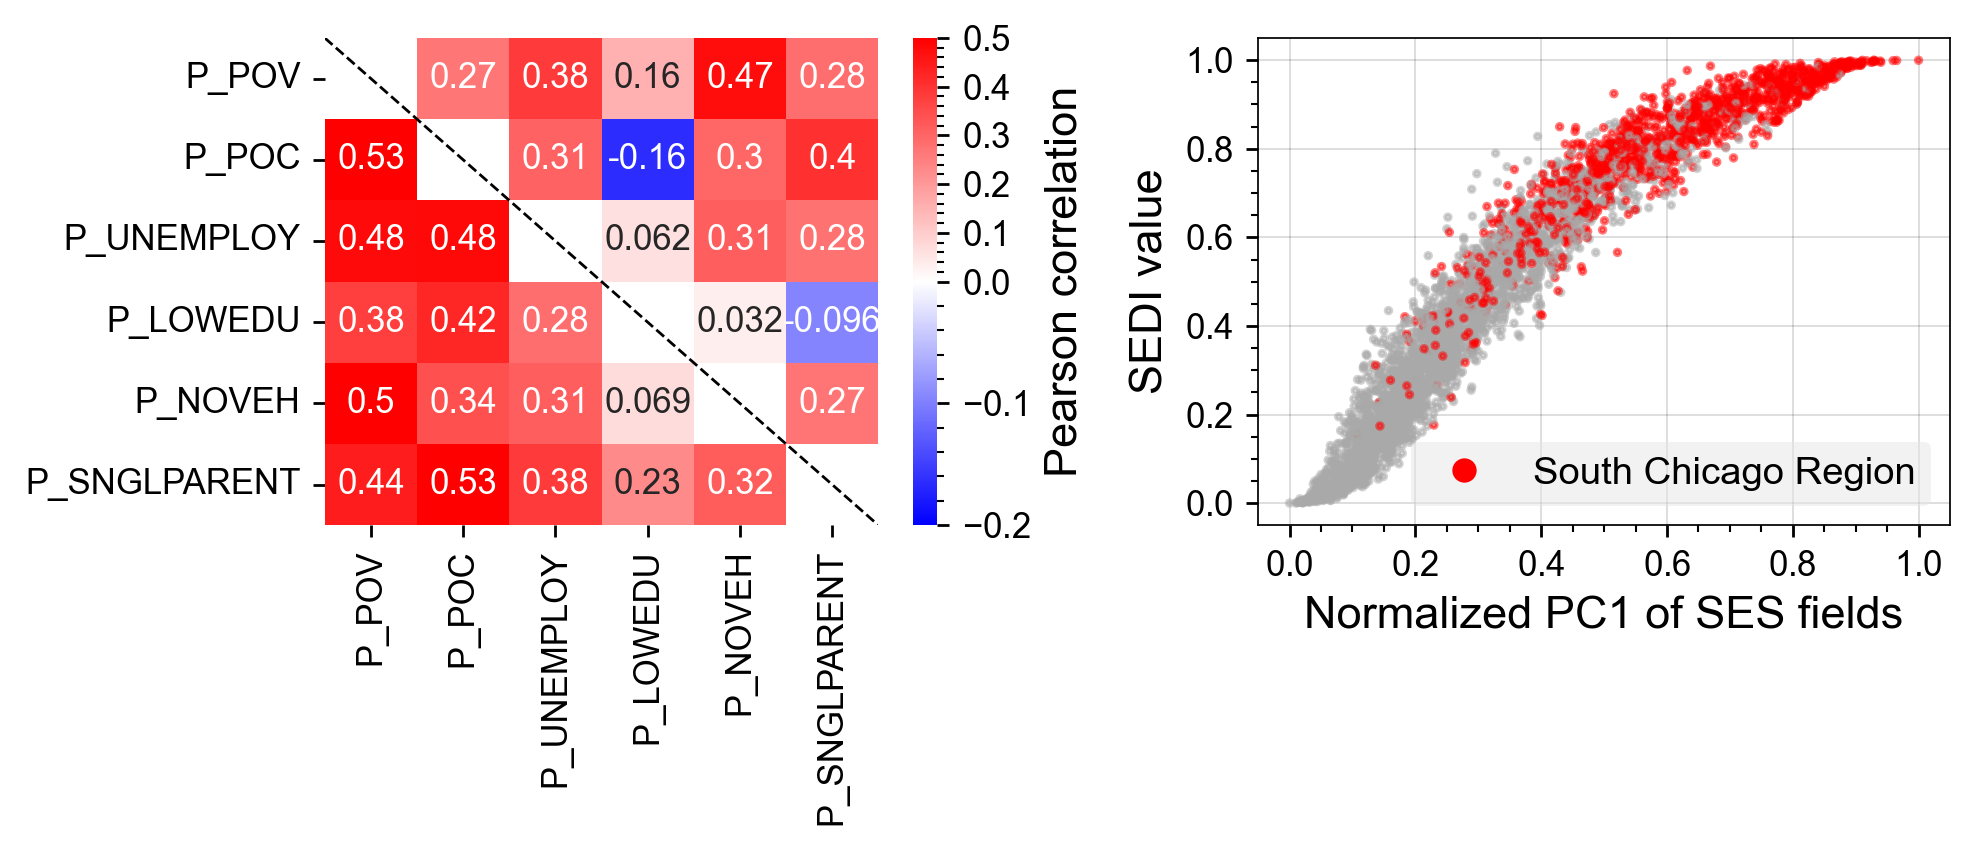

In [20]:
def plot_sedi_corr(size=(8, 3.5), dpi=150):
    cols = 'p_pov p_poc p_unemploy p_lowedu p_noveh p_snglparent'.split()
    ses = pd.read_parquet(DATA / 'ses/acs_2021.parquet')[['geoid'] + cols]
    ses_cook = ses.merge(bg_cook['geoid']).dropna().set_index('geoid')
    ses_schi = ses_cook.reset_index().merge(bg_schi['geoid']).set_index('geoid')
    sedi_cook = get_sedi(bg_cook, cols=cols)
    ## Part A
    corr_cook = np.tril(ses_cook.corr(), -1)
    corr_schi = np.triu(ses_schi.corr(), 1)
    cols = [x.upper() for x in ses_cook.columns]
    corr = corr_cook + corr_schi
    np.fill_diagonal(corr, np.nan)
    corr = Pdf(corr, columns=cols, index=cols)
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    ax = pplot(axes[0], gridcolor='w')
    norm = mpl.colors.TwoSlopeNorm(vmin=-0.2, vmax=0.5, vcenter=0)
    sns.heatmap(corr, ax=ax, annot=True, cmap='bwr', norm=norm,
                annot_kws=D(fontsize=10), vmin=-0.2, vmax=0.5,
                cbar_kws=D(label='Pearson correlation'))
    ax.minorticks_off()
    ax.plot([0, len(cols)], [0, len(cols)], '--k', lw=0.8)
    ## Part B
    pc1 = Pdf(normalize(PCA(1).fit_transform(ses_cook)), 
              columns=['pc1'], index=ses_cook.index)
    sedi = sedi_cook.merge(pc1, on='geoid')
    sedi['color'] = sedi.geoid.isin(ses_schi.index).map({True: 'r', False: 'darkgrey'})
    ax = pplot(axes[1], xlab='Normalized PC1 of SES fields', ylab='SEDI value')
    ax.scatter(sedi.pc1, sedi.sedi, c=sedi.color, s=3, alpha=0.5)
    ax.legend(handles=[mpl.lines.Line2D([0], [0], marker='o', color='r', lw=0, 
                                        label='South Chicago Region')])
    plt.tight_layout()

plot_sedi_corr(dpi=250)